In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score 
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.ticker as ticker

In [2]:
injuryData = pd.read_csv("~/Documents/Job Search - 2023/NBA_Injury_Predictor/Injuries.csv")

In [3]:
injuryData.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
injuryData.rename(columns={'Notes': 'Injury Type'}, inplace=True)
injuryData.rename(columns={'Relinquished': 'Player'}, inplace=True)

### We want to separate the dataset by year to get a good idea of the total number of injuries that have occured annually

In [4]:
# Setting the objects in the column to a pandas datetime object
injuryData['Date'] = pd.to_datetime(injuryData['Date'])

#Grouping rows by 'decade' column
injuryData['Year'] = (injuryData['Date'].dt.year)



### Let's now remove all rows where the players have been acquired back from the IL 


In [5]:
# Removing the Acquired column removes all duplicates 
injuryData = injuryData[injuryData['Acquired'].isna()]
del injuryData['Acquired']

### Now let's calculate the total sum of injuries for each Year

## `It is important to note that the NBA did not have and IR/IL until the 1989-1990 season. Prior to this injured players were still members of the active roster. For this reason, it's likely many injuries do not appear in the dataset.`

In [34]:
# We only want to include data from the years after 1989 
yearly_injuries = {}
total_injuries = 0
for year, group in injuryData.groupby('Year'):
    if year > 1989: 
        injuries = group.shape[0]
        yearly_injuries[year] = injuries
        total_injuries += injuries
#         print(f"Year: {year} Injuries: {injuries}")
#         print(f"Total Injuries: {total_injuries}")
#         print("---------------------------------------------")
df = pd.DataFrame(yearly_injuries.items(), columns=['Year', 'Injuries'])
condition1 = df['Year'].astype(int) <= 2015
df.loc[condition1, 'Players'] = 354

# Set the condition for the second range of years (1996 onwards)
condition2 = df['Year'].astype(int) > 2015
df.loc[condition2, 'Players'] = 450
    

In [7]:
def normalize_players(df):
  # Get the mean and standard deviation of the players feature.
  
  mean = df['Players'].mean()
  std = df['Players'].std()

  # Normalize the players feature.
  df['Normalized Players'] = (df['Players'] - mean) / std
#   df['Normalized Players'].fillna(mean, inplace=True)
  # Print the data frame.
    
  return df

normalize_players(df)


,Year,Injuries,Players,Normalized Players
0,1990,64,354.0,-0.546482
1,1991,66,354.0,-0.546482
2,1992,28,354.0,-0.546482
3,1993,33,354.0,-0.546482
4,1994,127,354.0,-0.546482
5,1995,245,354.0,-0.546482
6,1996,277,354.0,-0.546482
7,1997,290,354.0,-0.546482
8,1998,157,354.0,-0.546482
9,1999,396,354.0,-0.546482


In [8]:
# calculating the correlation for the two features I will use to train my model
Players_corr = df['Players'].corr(df['Injuries'])
Normalized_corr = df['Normalized Players'].corr(df['Injuries'])
Year_corr = df['Year'].corr(df['Injuries'])


print("Correlation for Players feature:", Players_corr)
print("Correlation for Year feature:", Year_corr)
print("Correlation for Players feature:", Normalized_corr)


Correlation for Players feature: 0.5759226257184823
Correlation for Year feature: 0.8285992890740163
Correlation for Players feature: 0.5759226257184822


In [9]:
#Using Linear Regression function to fit our model
train_data = df[:26]

X_train = np.array(train_data[['Year', 'Normalized Players']]).reshape(-1, 2)
y_train = train_data['Injuries']
reg = LinearRegression()


fit_model = reg.fit(X_train, y_train)
print(df.shape)
X_train.shape


(34, 4)


(26, 2)

In [10]:
# using a scikit-learn attribute, the coef represents the wieghts assigned to different features 
print(f"The Weight of feature(s): {fit_model.coef_}")

The Weight of feature(s): [35.01846154  0.        ]


In [11]:
# getting the intercept(bias) for our fitted model
print(f"The Bias of the model: {fit_model.intercept_}")

The Bias of the model: -69668.43076923072


In [12]:
# Adding our insample prediction for each year to our training data set
train_data.loc[:, 'prediction_insample'] = fit_model.predict(X_train).copy()
train_data.head()

/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_43322/1950665895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'prediction_insample'] = fit_model.predict(X_train).copy()


,Year,Injuries,Players,Normalized Players,prediction_insample
0,1990,64,354.0,-0.546482,18.307692
1,1991,66,354.0,-0.546482,53.326154
2,1992,28,354.0,-0.546482,88.344615
3,1993,33,354.0,-0.546482,123.363077
4,1994,127,354.0,-0.546482,158.381538


In [13]:
# Calculating the error, MSE, and ABS error for each year
train_data['error'] = train_data.prediction_insample - train_data.Injuries
train_data['squared_error'] = train_data['error']**2
train_data['abs'] = abs(train_data['error'])

train_data

/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_43322/2476111573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['error'] = train_data.prediction_insample - train_data.Injuries
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_43322/2476111573.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['squared_error'] = train_data['error']**2
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_43322/2476111573.py:4: SettingWithCopyWarning: 
A value is trying to 

,Year,Injuries,Players,Normalized Players,prediction_insample,error,squared_error,abs
0,1990,64,354.0,-0.546482,18.307692,-45.692308,2087.786982,45.692308
1,1991,66,354.0,-0.546482,53.326154,-12.673846,160.626376,12.673846
2,1992,28,354.0,-0.546482,88.344615,60.344615,3641.472606,60.344615
3,1993,33,354.0,-0.546482,123.363077,90.363077,8165.485671,90.363077
4,1994,127,354.0,-0.546482,158.381538,31.381538,984.800956,31.381538
5,1995,245,354.0,-0.546482,193.400000,-51.600000,2662.560000,51.600000
6,1996,277,354.0,-0.546482,228.418462,-48.581538,2360.165879,48.581538
7,1997,290,354.0,-0.546482,263.436923,-26.563077,705.597056,26.563077
8,1998,157,354.0,-0.546482,298.455385,141.455385,20009.625837,141.455385
9,1999,396,354.0,-0.546482,333.473846,-62.526154,3909.519915,62.526154


In [14]:
# I'm not sure why my error is zero 

# Returns the mean for error, squared error and absolute error for the training set
train_data[['error', 'squared_error', 'abs']].mean()

error            4.477512e-12
squared_error    2.104254e+04
abs              1.140656e+02
dtype: float64

Text(0.5, 1.0, 'Number of Injuries Year by Year')

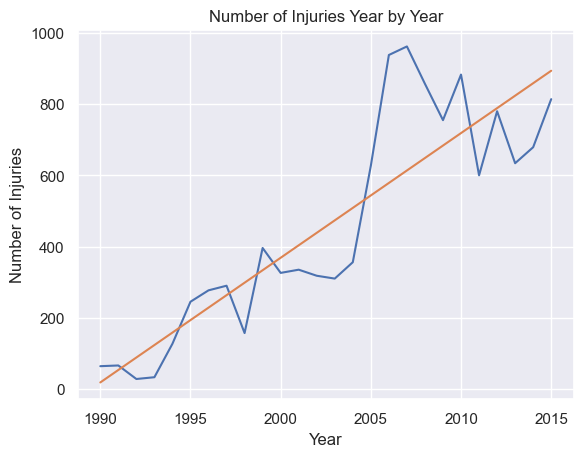

In [15]:
sns.set(style="darkgrid")
sns.lineplot(x=train_data['Year'], y=train_data['Injuries'], data=train_data)
sns.lineplot(x=train_data['Year'], y=train_data['prediction_insample'], data=train_data)
plt.xlabel('Year')
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries Year by Year')


### <u>Time to test on a new set of data:<u>

In [16]:
test_data = df[26:]
 
X_test = np.array(test_data[['Year', 'Players']]).reshape([-1, 2])
y_test = test_data['Injuries']
X_test

array([[2016.,  450.],
       [2017.,  450.],
       [2018.,  450.],
       [2019.,  450.],
       [2020.,  450.],
       [2021.,  450.],
       [2022.,  450.],
       [2023.,  450.]])

In [40]:
y_pred = fit_model.predict(X_test)
y_pred
# Adding our insample prediction for each year to our test data set
test_data.loc[:, 'prediction_insample'] = fit_model.predict(X_test).copy()
test_data.head()

array([ 928.78769231,  963.80615385,  998.82461538, 1033.84307692,
       1068.86153846, 1103.88      , 1138.89846154, 1173.91692308])

In [37]:
test_data['error'] = test_data.prediction_insample - test_data.Injuries
test_data['squared_error'] = test_data['error']**2
test_data['abs'] = abs(test_data['error'])

test_data

/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_43322/1205068349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['error'] = test_data.prediction_insample - test_data.Injuries
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_43322/1205068349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['squared_error'] = test_data['error']**2
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_43322/1205068349.py:3: SettingWithCopyWarning: 
A value is trying to be se

,Year,Injuries,Players,Normalized Players,prediction_insample,error,squared_error,abs
26,2016,835,450.0,1.776066,928.787692,93.787692,8796.131228,93.787692
27,2017,1172,450.0,1.776066,963.806154,-208.193846,43344.677576,208.193846
28,2018,1016,450.0,1.776066,998.824615,-17.175385,294.993837,17.175385
29,2019,866,450.0,1.776066,1033.843077,167.843077,28171.298471,167.843077
30,2020,570,450.0,1.776066,1068.861538,498.861538,248862.834556,498.861538
31,2021,1582,450.0,1.776066,1103.880000,-478.120000,228598.734400,478.120000
32,2022,1182,450.0,1.776066,1138.898462,-43.101538,1857.742618,43.101538
33,2023,506,450.0,1.776066,1173.916923,667.916923,446113.016133,667.916923


In [38]:
df.describe()["Injuries"]

count      34.000000
mean      576.058824
std       381.342282
min        28.000000
25%       295.000000
50%       585.000000
75%       851.500000
max      1582.000000
Name: Injuries, dtype: float64

In [49]:
print(X_test[:])

[[2016.  450.]
 [2017.  450.]
 [2018.  450.]
 [2019.  450.]
 [2020.  450.]
 [2021.  450.]
 [2022.  450.]
 [2023.  450.]]


ValueError: x and y must have same first dimension, but have shapes (2,) and (8,)

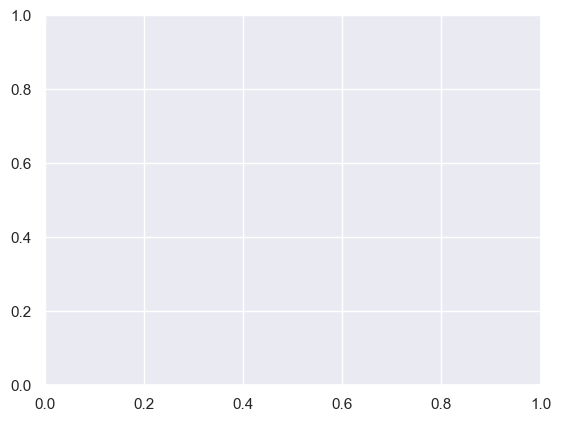

In [44]:

plt.plot(X_test[0], y_pred, 'r-', label='Predicted Data')
sns.set(style="darkgrid")
sns.lineplot(x=test_data['Year'], y=test_data['Injuries'], data=test_data)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries Year by Year')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

In [21]:
# Now let's remove all the rows from the data frame that have data before 1990
injuryData = injuryData[injuryData['Year'] >= 1990]